# Extract information from old doc

# setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# get information

In [ ]:
import pandas as pd
import numpy as np

# unifies condition (GD, EX, etc) and subcondition (+,-)
def unify_condition(data_frame):
  data_frame['subcondition'].fillna('', inplace=True)
  # Convert 'Condition' to string
  data_frame['Condition'] = data_frame.apply(lambda row: row['Condition'] if row['Condition'] in ['PO', 'PL', 'LP', np.nan] else row['Condition'] + row['subcondition'], axis=1)
  data_frame.drop('subcondition', axis=1, inplace=True)
  return data_frame

def is_in_collection(row):
  comments = row['Comments']
  if pd.notnull(comments) and isinstance(comments, str):  # Check if not NaN and a string
      comments = comments.lower()
      return 'kept' in comments
  return False

def define_in_collection(data_frame):
  # create a new column 'in collection' and its value is True if 'kept' is in 'Comments'
  data_frame['in collection'] = data_frame.apply(is_in_collection, axis=1)
  # remove 'kept' from the 'Comments'. If it's now an empty comment, it is set to NaN
  data_frame['Comments'] = data_frame['Comments'].str.replace(r'\bkept\b', '', regex=True).str.strip().apply(lambda x: np.nan if x=='' else x)
  return data_frame

def split_source_and_seller(data_frame):
    # split the concept of sellers and sources
    data_frame['seller'] = None
    data_frame['source'] = None
    for index, row in data_frame.iterrows():
      if pd.notnull(row['Source']):
        parts = row['Source'].split('\n', 1)
        if len(parts) == 2:
          seller, source = parts
          data_frame.at[index, 'seller'] = seller.strip()
          data_frame.at[index, 'source'] = source.strip()
        else:
          data_frame.at[index, 'source'] = row['Source'].strip()

    data_frame.drop('Source', axis=1, inplace=True)
    return data_frame

def convert_to_real_BS_prices(data_frame):
  # Convert the 'B-Price' and 'S-Price' columns to real values
  data_frame['B-Price'] = data_frame['B-Price'].astype(float)
  data_frame['S-Price'] = data_frame['S-Price'].astype(float)
  return data_frame

def get_data(xlsx_file):
  data_frame = pd.read_excel(xlsx_file)

  data_frame = convert_to_real_BS_prices(data_frame)
  data_frame = split_source_and_seller(data_frame)
  data_frame = define_in_collection(data_frame)
  #data_frame = manage_scambiato_con_il_nostro(data_frame)
  data_frame = unify_condition(data_frame)

  return data_frame

# extract from file

In [ ]:
from datetime import datetime
file_path = './drive/MyDrive/pkmn/PokémonCards 2023_sw.xlsx'

df = get_data(file_path)
df

df.to_csv('./pok_swap.csv')

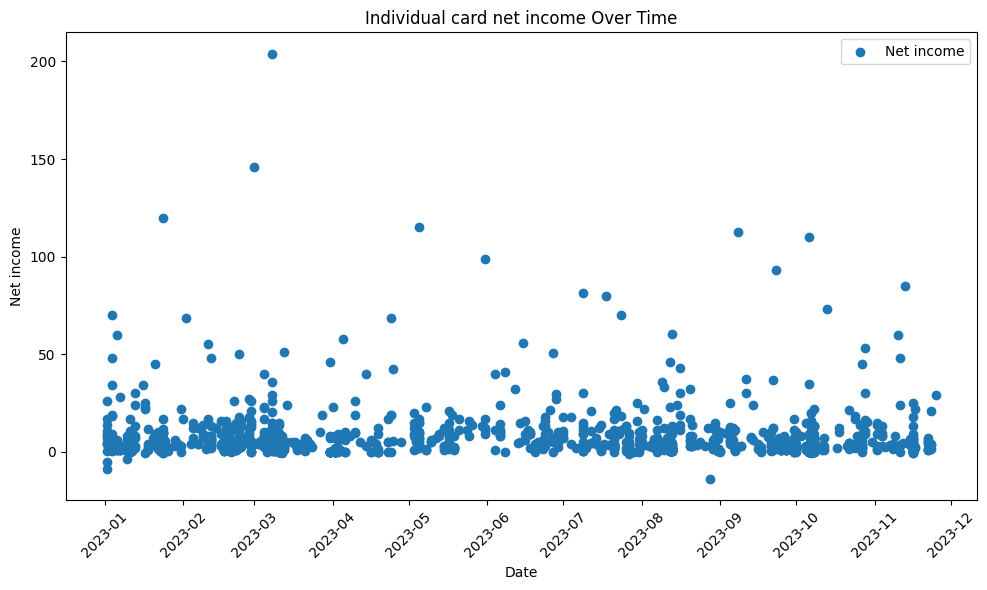

Number of scatter points: 1387


In [ ]:
### Just a random plot ###

import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is named 'df'
# Load your dataset here
# df = pd.read_csv('your_dataset.csv')

# Convert 'B-Date' column to datetime
df['S-Date'] = pd.to_datetime(df['S-Date'], errors='coerce')
df = df[df['S-Date'] >= '2023-01-01']

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['S-Date'], df['E'], label='Net income')
plt.xlabel('Date')
plt.ylabel('Net income')
plt.title('Individual card net income Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Count the number of scatter points
scatter_count = len(df)
print(f"Number of scatter points: {scatter_count}")
